## Group project 

In [1]:
#Import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
sns.set_theme(style="darkgrid")
random.seed(10)
import math
import scipy.stats

/Users/polinab/.virtualenvs/base/lib/python3.8/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## Generate the synthetic data set 

In [2]:
bernoulli = random.random()
print(f'Random bernoulli variable is assigned as {bernoulli}')
x = np.random.uniform(0, 10, 1000)
label = np.random.binomial(1, bernoulli, 1000)
noise_a = np.random.normal(0, 1, 1000) 
noise_b = np.random.normal(0, 3, 1000)
d = {'x': x, 'label': label, 'noise_a': noise_a, 'noise_b': noise_b}
df = pd.DataFrame(data=d)
df.loc[df.label == 0, 'y'] = df.x * 3 + 2 + df.noise_a
df.loc[df.label == 1, 'y'] = df.x * 4 + 4 + df.noise_b
df

Random bernoulli variable is assigned as 0.5714025946899135


,x,label,noise_a,noise_b,y
0,0.910344,0,-0.103690,-3.879010,4.627344
1,1.835587,1,1.803941,-1.640640,9.701709
2,7.861089,1,-1.671970,-3.168121,32.276235
3,3.527295,0,-0.935497,0.367782,11.646388
4,3.097797,1,-0.589279,-0.284493,16.106697
...,...,...,...,...,...
995,7.762866,0,1.417862,-6.936471,26.706462
996,3.499183,0,0.590884,-3.660504,13.088434
997,7.059917,1,-0.342515,-2.049389,30.190280
998,4.539989,0,-0.784242,-0.534432,14.835724


## Plotting the data for a first overview 

<AxesSubplot:xlabel='x', ylabel='y'>

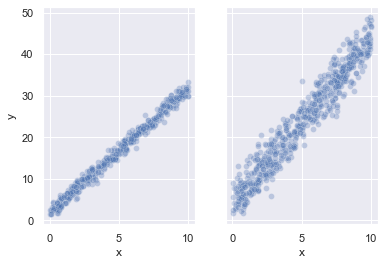

In [3]:
fig, ax =plt.subplots(1,2, sharey=True)
sns.scatterplot(data=df[df.label == 0],x='x', y='y', alpha=0.3,ax=ax[0])
sns.scatterplot(data=df[df.label == 1],x='x', y='y', alpha=0.3,ax=ax[1])


<AxesSubplot:xlabel='x', ylabel='y'>

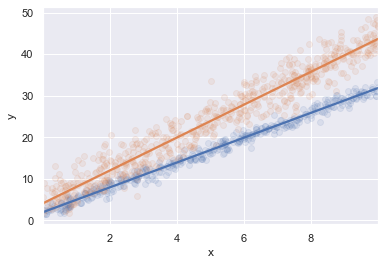

In [4]:
sns.regplot(data=df[df.label == 0],x='x', y='y',scatter_kws={'alpha':0.1})
sns.regplot(data=df[df.label == 1],x='x', y='y',scatter_kws={'alpha':0.1})


<AxesSubplot:xlabel='x', ylabel='Density'>

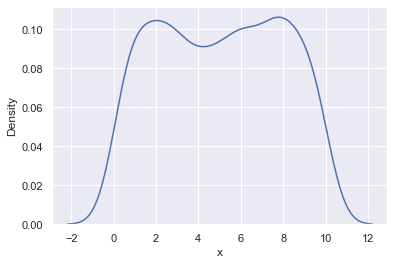

In [5]:
sns.kdeplot(data=df.x)

# Second part: mathematical background 

To Do !

# Third part: Implementation of the EM algorithm 

## Initialization 

In [6]:
def initialize_parameter_list(d):
    d['variance_a']=random.randint(1, 3)
    d['variance_b']=random.randint(1, 3)
    d['beta_a0'] = random.uniform(0,5)
    d['beta_a1'] = random.uniform(0,5)
    d['beta_b0'] = random.uniform(0,5)
    d['beta_b1'] = random.uniform(0,5)
    d['prob_a'] = random.random()
    d['prob_b'] = 1 - d['prob_a']
    return d

In [7]:
# initialization of the parameter
params = initialize_parameter_list({})
params

{'variance_a': 2,
 'variance_b': 2,
 'beta_a0': 2.890456505672352,
 'beta_a1': 1.0304911606975087,
 'beta_b0': 4.0666062567866,
 'beta_b1': 4.117944362667227,
 'prob_a': 0.6534725339011758,
 'prob_b': 0.34652746609882423}

## Setting the weights 

## Expectation step

In [8]:
##Expectation step
def Estep(p):
   
    #Set the values for the algorithm
    w_a_numerator  = p['prob_a'] * (1/np.sqrt(2*np.pi*p['variance_a'])) * np.exp((-(1/(2*p['variance_a'])) * (df.y - p['beta_a0'] - p['beta_a1']*df.x)**2))
    w_b_numerator  = p['prob_b'] * (1/np.sqrt(2*np.pi*p['variance_b'])) * np.exp((-(1/(2*p['variance_b'])) * (df.y - p['beta_b0'] - p['beta_b1']*df.x)**2))
    p['w_sum'] = w_a_numerator + w_b_numerator
    p['w_a'] = w_a_numerator/p['w_sum']
    p['w_b'] = w_b_numerator/p['w_sum']
    
    return p


## Maximisation step

In [9]:
## Maximisation step:
def Mstep(p, df):

    #Update the function following the derived update rules:
    
    #Update the prior beliefs
    p['prob_a'] = p['w_a'].sum()/(p['w_a'].sum() +p['w_b'].sum()).sum()
    p['prob_b'] = p['w_b'].sum()/(p['w_a'].sum() +p['w_b'].sum()).sum()
    
    #Update the betas for each subgroup
    #Beta_0
    
    p['beta_a0'] = ((df.y - p['beta_a1']*df.x)*p['w_a']).sum()/p['w_a'].sum() 
    p['beta_b0'] = ((df.y - p['beta_b1']*df.x)*p['w_b']).sum()/p['w_b'].sum() 
  
    #New beta formula
    p['beta_a1'] = ((df.y*df.x - p['beta_a0']*df.x)*p['w_a']).sum()/(p['w_a']*df.x**2).sum() 
    p['beta_b1'] = ((df.y*df.x - p['beta_b0']*df.x)*p['w_b']).sum()/(p['w_b']*df.x**2).sum() 
    #print('beta1', beta_a1, beta_b1)
    
    #Update the variance 
    #Define the residuals first
    e_hat_a = df.y - p['beta_a0']-p['beta_a1']*df.x
    e_hat_b = df.y - p['beta_b0']-p['beta_b1']*df.x
    #print('ehat', e_hat_a, e_hat_b)
    
    #Define the variance 

    p['variance_a'] = ((e_hat_a**2)*p['w_a']).sum()/p['w_a'].sum()
    p['variance_b'] = ((e_hat_b**2)*p['w_b']).sum()/p['w_b'].sum()

    return p
    

In [10]:
Mstep(Estep(params),df)


{'variance_a': 6.697307990420031,
 'variance_b': 23.402880072119896,
 'beta_a0': 6.064252323583605,
 'beta_a1': 1.6773390515252762,
 'beta_b0': 0.8329815356920248,
 'beta_b1': 3.9813301199034425,
 'prob_a': 0.19844905195615734,
 'prob_b': 0.8015509480438427,
 'w_sum': 0      1.648644e-01
 1      3.918900e-02
 2      1.286725e-03
 3      2.625188e-04
 4      8.598036e-02
            ...     
 995    3.504262e-11
 996    7.249305e-05
 997    1.112041e-02
 998    3.552889e-07
 999    6.960381e-02
 Length: 1000, dtype: float64,
 'w_a': 0      9.532773e-01
 1      1.108170e-02
 2      9.262841e-48
 3      9.978447e-01
 4      2.640649e-11
            ...     
 995    3.633072e-18
 996    4.866026e-02
 997    4.819182e-43
 998    9.584783e-01
 999    9.950017e-07
 Length: 1000, dtype: float64,
 'w_b': 0      0.046723
 1      0.988918
 2      1.000000
 3      0.002155
 4      1.000000
          ...   
 995    1.000000
 996    0.951340
 997    1.000000
 998    0.041522
 999    0.999999
 Length

## Defining the average likelihood function

In [11]:
def get_avg_log_likelihood(p,df):
    
    Q_function_a = -1/2*((p['w_a']*((df.y-p['beta_a0']-p['beta_a1']*df.x)**2-math.log(p['variance_a']))).sum())
    Q_function_b = -1/2*((p['w_b']*((df.y-p['beta_b0']-p['beta_b1']*df.x)**2-math.log(p['variance_b']))).sum())
    
    Q_function = Q_function_a + Q_function_b
    
    return Q_function

In [12]:
def run_em(p,df):
    avg_loglikelihoods = []
    p = initialize_parameter_list(p) #initialize params
    
    while True: 
        p = Mstep(Estep(p),df) # EM step
                
        #Evaluate the loglikelihood function
        avg_loglikelihood = get_avg_log_likelihood(p,df)
        avg_loglikelihoods.append(avg_loglikelihood)
        slope = 1/avg_loglikelihood
        if len(avg_loglikelihoods)>2 and (avg_loglikelihoods[-1] - avg_loglikelihoods[-2]) < 0:
            break
        if len(avg_loglikelihoods) > 2 and abs(avg_loglikelihoods[-1] - avg_loglikelihoods[-2]) < 0.0001: #Define a stopping criterion
            break
    
    return p, avg_loglikelihoods


In [13]:
new_params, log_likelies = run_em(params, df)

In [14]:
log_likelies[:10]

[-4906.895190644336,
 -3558.318392062067,
 -3126.5883059293114,
 -2969.780026968755,
 -2897.810030184955,
 -2855.962169942508,
 -2827.6861345214097,
 -2807.0713250368913,
 -2790.953520496878,
 -2777.181993792531]

## Plotting the iterations 

In [15]:
iterations = np.arange(0,len(log_likelies),1)
data_log = pd.DataFrame(data={'logs': log_likelies, 'iterations': iterations})

In [16]:
data_log

,logs,iterations
0,-4906.895191,0
1,-3558.318392,1
2,-3126.588306,2
3,-2969.780027,3
4,-2897.810030,4
...,...,...
95,-2181.246425,95
96,-2181.246282,96
97,-2181.246161,97
98,-2181.246060,98


<AxesSubplot:xlabel='iterations', ylabel='logs'>

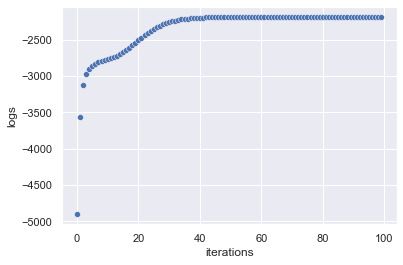

In [17]:
sns.scatterplot(x = 'iterations', y = 'logs', data = data_log)

In [35]:
betas_a0 = []
betas_a1 = []
betas_b0 = []
betas_b1 = []
iterations = []
i = 0

for i in range(0,100):
    parameter_list = initialize_parameter_list({})
    try:
        new_params, log_likelies = run_em(parameter_list, df)
    except:
        "math error"
    betas_a0.append(new_params['beta_a0'])
    betas_a1.append(new_params['beta_b0'])
    betas_b0.append(new_params['beta_a1'])
    betas_b1.append(new_params['beta_b1'])
    i+= 1
    iterations.append(i)

Text(0.5, 1.0, 'Beta B1')

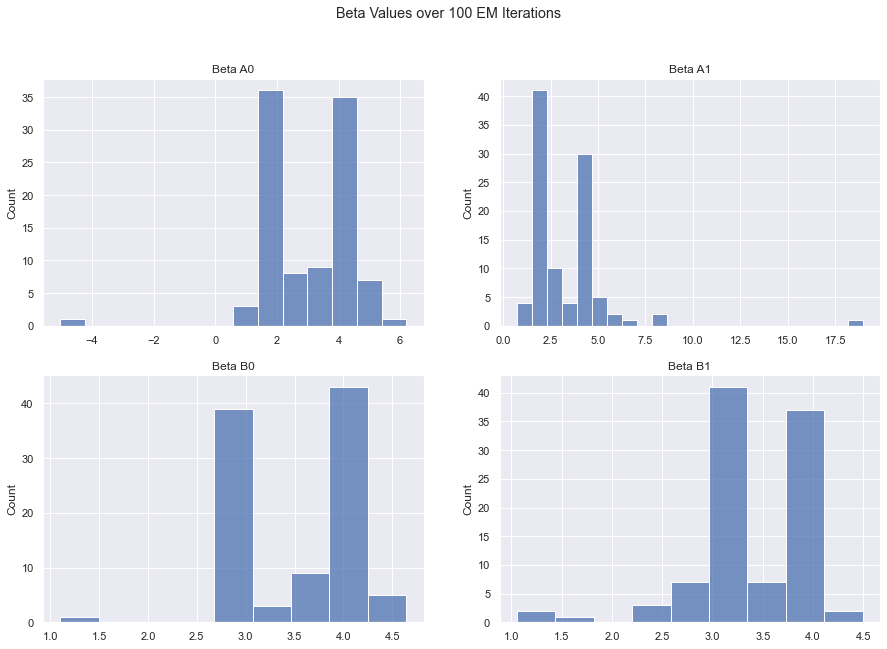

In [48]:
# sns.scatterplot(x = betas_a0, y = iterations)
fig, axes = plt.subplots(2, 2, figsize=(15,10))
fig.suptitle(f'Beta Values over {i} EM Iterations')
sns.histplot(x=betas_a0, ax=axes[0, 0]).set_title('Beta A0')
sns.histplot(x=betas_a1, ax=axes[0, 1]).set_title('Beta A1')
sns.histplot(x=betas_b0, ax=axes[1, 0]).set_title('Beta B0')
sns.histplot(x=betas_b1, ax=axes[1, 1]).set_title('Beta B1')